**Spectral analysis**

Change these parameters! Set the folder of EEG files.

*NB! The path has to be in 'Data\Clean\' folder relative to this notebook.*

In [1]:
"""
VARIABLES TO CHANGE
exp_folder: A relative folder location of the experiment (e.g. r"Eyes Closed\Baseline")
exp_condition: A short code of the experiment which will be used for exporting (e.g. r"EC_00")
b_names: A list of bands names
b_freqs: A list of bands' frequency ranges
"""
exp_folder = r"Eyes Closed\test"
exp_condition = r"EC_test"
b_names = ['Delta','Theta','Alpha','Low-Beta','High-Beta']
b_freqs = [[1,3.9],[4,7.9],[8,12],[12.1,18],[18.1,30]]
brain_regions = {'Frontal':['Fp1','Fp2','AF3','AF4','F3','F4','F7','F8','Fz'],
                 'Temporal':['FC5','FC6','T7','T8','CP5','CP6','P7','P8'],
                 'Centro-parietal':['FC1','FC2','C3','C4','Cz','CP1','CP2','P3','P4','Pz'],
                 'Occipital':['PO3','PO4','O1','O2','Oz']}

Just run this script! It conducts spectral analysis on clean EEG files and save the results regionally and channel-by-channel in Excel format.
It does the following step-by-step:
1. Read raw FIF file (cleaned EEG file)
2. Calculate power spectrum density for the current file
3. Calculate bandpower for each frequency band of interest (e.g., delta, theta, alpha, low-beta, high-beta)
4. Split the signal to half for each band and plot the comparison if the median absolute deviation is over 2 across the signal
5. Plot all the frequency bands topographically
6. Attempt to create a folder and save the bandpowers regionally and channel-by-channel to Excel files

Files in folder: 9


c:\Users\TANIJARV\Downloads\Ketamine-SI project\eeg-pipeline\signal_processing\spectral_analysis.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,(ax1,ax2) = plt.subplots(ncols=2)


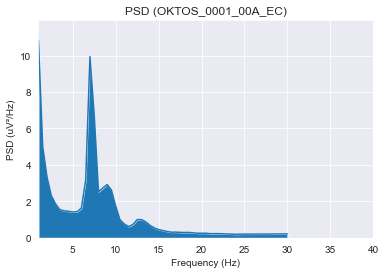

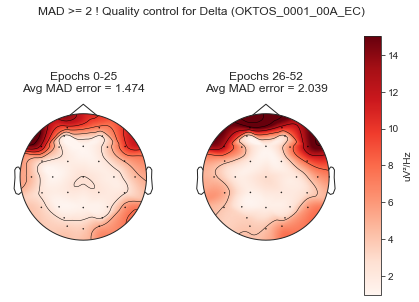

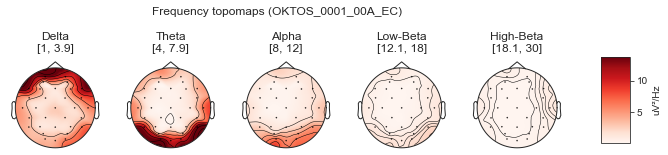

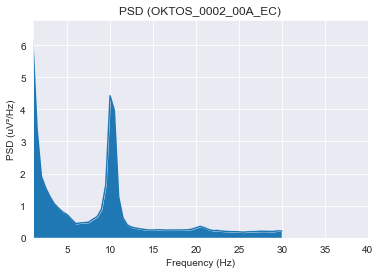

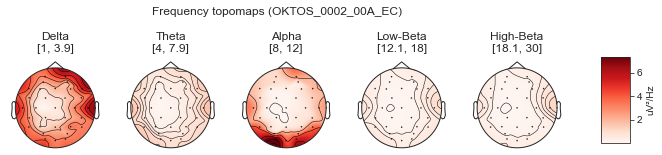

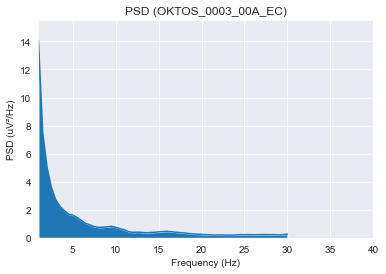

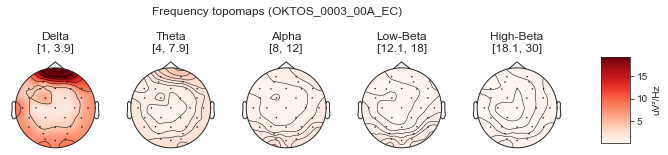

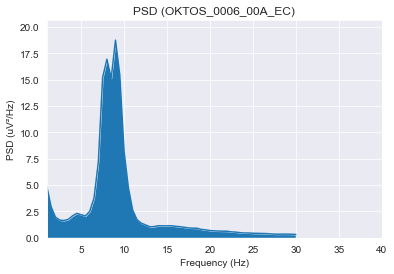

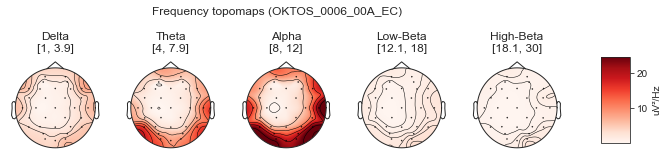

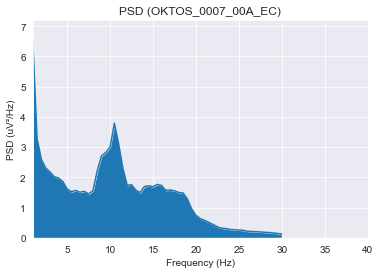

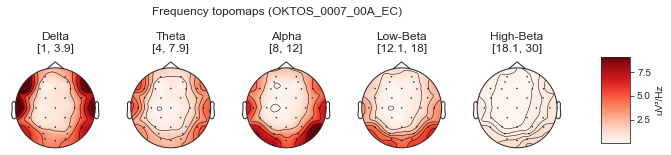

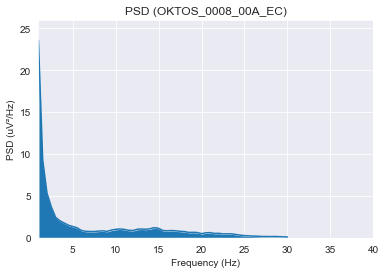

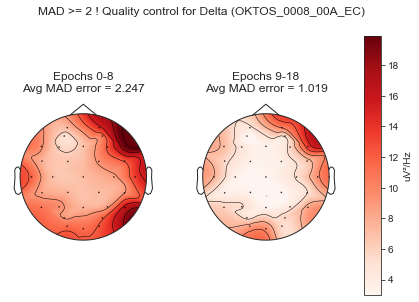

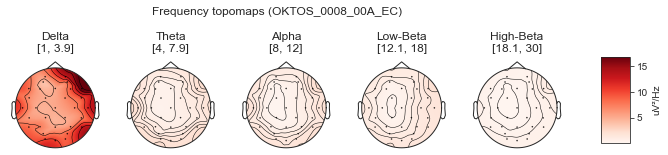

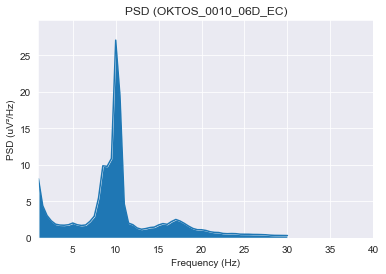

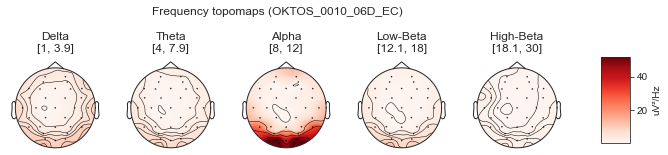

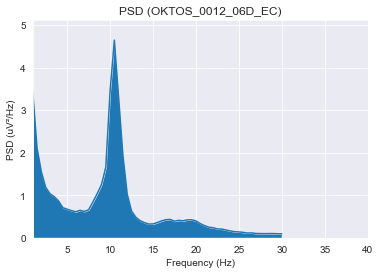

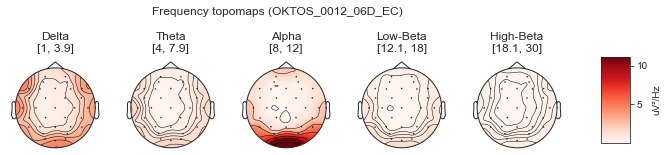

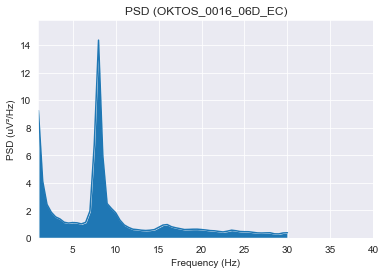

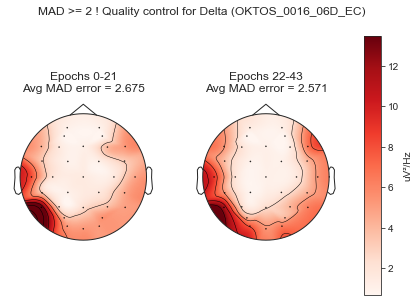

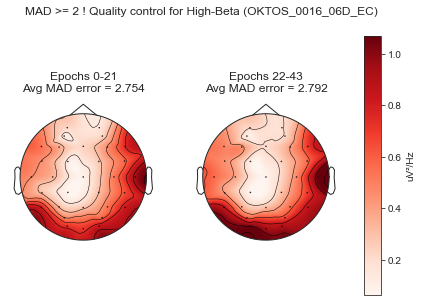

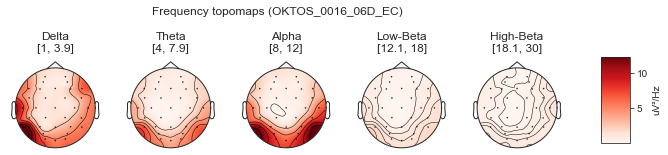

In [2]:
import os, mne
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from signal_processing.spectral_analysis import *
from basic.arrange_data import *

clean_folder = r"Data\Clean"
dir_inprogress = os.path.join(clean_folder,exp_folder)
file_dirs, subject_names = read_files(dir_inprogress,"_clean-epo.fif")
df_faa = pd.DataFrame(columns=['Pre-frontal','Mid-frontal','Lateral-frontal'])

# Go through all the files (subjects) in the folder
for i in range(len(file_dirs)):
    # Read the clean data from the disk
    epochs = mne.read_epochs(fname='{}\{}_clean-epo.fif'.format(dir_inprogress,subject_names[i]),verbose=False)
    
    # Calculate Welch's power spectrum density (FFT)
    [psds,freqs] = calculate_psd(epochs,subject_names[i],fminmax=[1,30],window='hamming',window_duration=2,window_overlap=0.5)

    # Total PSD of chosen frequency range (for later relative PSD calculation)
    psd_ch_allbands = bandpower_per_channel(psds,freqs,[b_freqs[0][0],b_freqs[-1][-1]],'All bands',subject_names[i],epochs)
    
    # Find power for all bands and add to dataframe including the previous subjects
    vmin = float('inf')
    vmax = 0
    for j in range(len(b_names)):
        if i == 0:
            globals()["df_psd_"+b_names[j]] = pd.DataFrame()
            globals()["df_rel_psd_"+b_names[j]] = pd.DataFrame()
        
        # Devide the PSD to frequency band bins and calculate absolute and relative bandpowers
        globals()["psd_ch_"+b_names[j]] = bandpower_per_channel(psds,freqs,b_freqs[j],b_names[j],subject_names[i],epochs)
        globals()["rel_psd_ch_"+b_names[j]] = globals()["psd_ch_"+b_names[j]] / psd_ch_allbands

        # Convert the array to dataframe and concatenate it to dataframe including the previous subjects
        globals()["temp_df_psd_"+b_names[j]] = array_to_df(subject_names[i],epochs,globals()["psd_ch_"+b_names[j]])
        globals()["df_psd_"+b_names[j]] = pd.concat([globals()["df_psd_"+b_names[j]],globals()["temp_df_psd_"+b_names[j]]])
        globals()["temp_df_rel_psd_"+b_names[j]] = array_to_df(subject_names[i],epochs,globals()["rel_psd_ch_"+b_names[j]])
        globals()["df_rel_psd_"+b_names[j]] = pd.concat([globals()["df_rel_psd_"+b_names[j]],globals()["temp_df_rel_psd_"+b_names[j]]])

        # Save the minimum and maximum PSD values as an integer for later colorbar use
        vmin = min([vmin,min(globals()["psd_ch_"+b_names[j]])])
        vmax = max([vmax,max(globals()["psd_ch_"+b_names[j]])])

    # Plot topomaps for all bands
    sns.set_style("white",{'font.family': ['sans-serif']})
    fig,axs = plt.subplots(nrows=1,ncols=len(b_names),figsize=(10,3))
    fig.suptitle("Frequency topomaps ({})".format(subject_names[i]))
    for topo in range(len(b_names)):
        im,_ = mne.viz.plot_topomap(globals()["psd_ch_"+b_names[topo]],epochs.info,axes=axs[topo],vmin=vmin,vmax=vmax,show=False)
        axs[topo].set_title(b_names[topo]+'\n'+str(b_freqs[topo]))
    cbar_ax = fig.add_axes([0.95,0.35,0.04,0.4])
    clb = fig.colorbar(im, cax=cbar_ax)
    clb.ax.set_ylabel('uV\u00b2/Hz')

# Calculate alpha asymmetry for three channel pairs
df_faa['Pre-frontal'] = calculate_asymmetry_ch(df_psd_Alpha,'Fp1','Fp2')
df_faa['Mid-frontal'] = calculate_asymmetry_ch(df_psd_Alpha,'F3','F4')
df_faa['Lateral-frontal'] = calculate_asymmetry_ch(df_psd_Alpha,'F7','F8')

# Pre-create results folders for spectral analysis data
create_results_folders(exp_folder)

# Export asymmetry data
df_faa.to_excel(r"Results\Absolute PSD\{}_frontal_asymmetry.xlsx".format(exp_condition))

# Export power spectra data for each band
for band in b_names:
    export_psd_results(globals()["df_psd_"+band],globals()["df_rel_psd_"+band],exp_folder,exp_condition,band,brain_regions)